## Using networkx on large graphs (Wordnet)

For this notebook you need some homegrown code, provided in the next cell.

You should also have nltk and the wordnet corpus (which may need to be downloaded
via `nltk.download()`) illustrated below.

Executing the first cell should give you a pretty good idea of whether you've
got the basics.

Execute the next code cell, which defines code used in this notebook.

In this notebook we work with the WordNet graph,  which is a very large graph, much too large
to draw, at least if we want a meaningful picture.
What  we do below is extract two sizable subgraphs of WordNet.

The first subgraph consists of specializations of the word `dog` (Schnauser,Cocker Spaniel, Border Collie, etcetera).
This `networkx` graph is called `dog_nw` below. The variable `dog` is set to be the first (most important) concept associated with the word *dog*.  This is used as a starting point for a traversal of the WordNet graph which follows only **hyponym** links (more specific than).

The second subgraph does the same for `person`.

In [1]:
import networkx as nx
import matplotlib
import sys,random
from nltk.corpus import wordnet as wn
from collections import Counter
import math
import nltk

def traverse(graph, start, node, rel='hyponyms',max_depth=None,prob=1.0,
             do_leaves=True):
    """
    This calls itself recursively following links
    of type C{rel} extending from C{child}.  C{Start} is the
    node the recursive traversal started at, passed in
    so that we can compute the depth of the traversal thus far.
    This is not the same as the depth of the recursion,
    which could be computed more easily.  The depth
    of the traversal is defined as the shortest distance
    between the start and node.  'rels' is a string
    that is turned into a method with C{getattr} so it must be legal
    method name on C{node}, and it must return a container of nodes
    (e.g., hyponyms,hypernyms, antonyms)

    prob is the prob that a node should be included. So prob=1.0 means
    include all nodes.
    """
    depth = node.shortest_path_distance(start)
    graph.depth[node.name] = depth
    #for child in node.hyponyms():
    for child in getattr(node,rel)():
        if random.random() > prob:
            continue
        if do_leaves or getattr(child,rel)():
            graph.add_edge(node.name().split('.')[0],
                           child.name().split('.')[0]) # [_add-edge]
        else:
            continue
        if (max_depth is None) or depth < max_depth:
            traverse(graph, start, child, rel=rel,max_depth=max_depth) # [_recursive-traversal]
        else:
            graph.depth[child.name] = child.shortest_path_distance(start)
            

def rel_graph(start,rel='hyponyms',max_depth=None,prob=1.0,do_leaves=True,graph_in=None):
    if graph_in is None:
        G = nx.Graph() # [_define-graph]
        G.depth = {}
    else:
        G = graph_in
    traverse(G, start, start,rel=rel,max_depth=max_depth,prob=prob,do_leaves=do_leaves)
    return G


Downlioading WordNet (if necessary).

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/gawron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Get the dog subgraph (actually a subsample, explained below).

In [2]:
from nltk.corpus import wordnet as wn
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.pyplot.switch_backend('QT4Agg')

dog= wn.synsets('dog','n')[0]
dog_nw = rel_graph(dog,rel='hyponyms',max_depth=3,prob=.8)

In [4]:
dog_nw

In [27]:
len(dog_nw.nodes())

176

We only used the first of the meaning concepts connected with the word `dog`, the concept associated with the pet.

In [6]:
dog_l = wn.synsets('dog','n')
dog_l

[Synset('dog.n.01'),
 Synset('frump.n.01'),
 Synset('dog.n.03'),
 Synset('cad.n.01'),
 Synset('frank.n.02'),
 Synset('pawl.n.01'),
 Synset('andiron.n.01')]

Here's another meaning of the word which would lead to a completely different subgraph of concepts.

In [9]:
print(dog_l[2].definition())

informal term for a man


Get the entire person subgraph

In [10]:
person = wn.synsets('person','n')[0]
#person_nw = c_nx.rel_graph(person,rel='hyponyms',max_depth=3,prob=.8)
#person_nw = c_nx.rel_graph(person,rel='hyponyms')
person_nw = rel_graph(person)

This is pretty big.

In [11]:
len(person_nw)

6261

Make it smaller, don't descend deeper than 3 levels.

In [12]:
person_nw = rel_graph(person,max_depth=3)
len(person_nw)

5092

Still pretty big.  Take a sample of this graph, using the `prob` parameter.

In [13]:
person_nw = rel_graph(person,max_depth=3,prob=.1)
len(person_nw)

1079

#### Drawing a SubGraph of a very large graph


What these cells do is draw the `dog_nw` subgraph of WordNet that we extracted above.

One issue is the labels, which are needed, but tend to overlap a lot. 
We write some code to address the problem  with abbreviations and truncations.


In [4]:
# qt, wx, gtk, osx, tk, empty uses default
#matplotlib tk
#from matplotlib import pyplot as plt
#plt.figure(figsize=(17,10)) 
#fac=6
#K=1/math.sqrt(len(dog_nw.nodes()))
#seed=58
#pos = nx.spring_layout(dog_nw,scale=5.0,k=fac*K,seed=seed) 

def strip_suff (wd,suff):
    suff_len = len(suff)
    if wd.endswith(suff):
        return wd[:-suff_len]
    else:
        return wd

def strip_pref (wd,pref):
    pref_len = len(pref)
    if wd.startswith(pref):
        return wd[pref_len:]
    else:
        return wd

def truncate_name (nm,redundant='dog'):
    def informative (pt):
        if pt in ['dog']:
            return False
        else:
            return True
    return abbrev(strip_suff('_'.join([pt for pt in nm.split('_') if informative(pt)]),redundant))

abbrev_dict = \
    dict(bullterrier = 'bllterr',
         terrier = 'terr',
         retriever = 'rtrvr',
         hound='hd',
         toy = 't.',
         spaniel = 'spnl',
         hund = 'hd',
         setter = 'sttr',
         shepherd = 'shprd',
         mastiff = 'mstff',
         collie = 'cll',
         greater = 'grtr',
         lesser = 'lssr',
         miniature ='mntr',
         pointer = 'ptr',
         hunde  = 'hd',
         west  = 'w',
         east = 'e',
         north = 'n',
         south = 's',
         poodle = 'pdl')
 
def abbrev (nm):
    nm = strip_suff(nm,'dog')
    change = ''
    for k in abbrev_dict.keys():
        if nm.endswith(k):
            cand = strip_suff(nm,k)
            if cand:
                change = cand + abbrev_dict[k]
        if change:
            # toy spaniel => t. spnl
            nm = change
        if nm.startswith(k):
            cand = strip_pref(nm,k)
            if cand:
                change = abbrev_dict[k] + cand
    if change:
        return change
    else:
        return nm

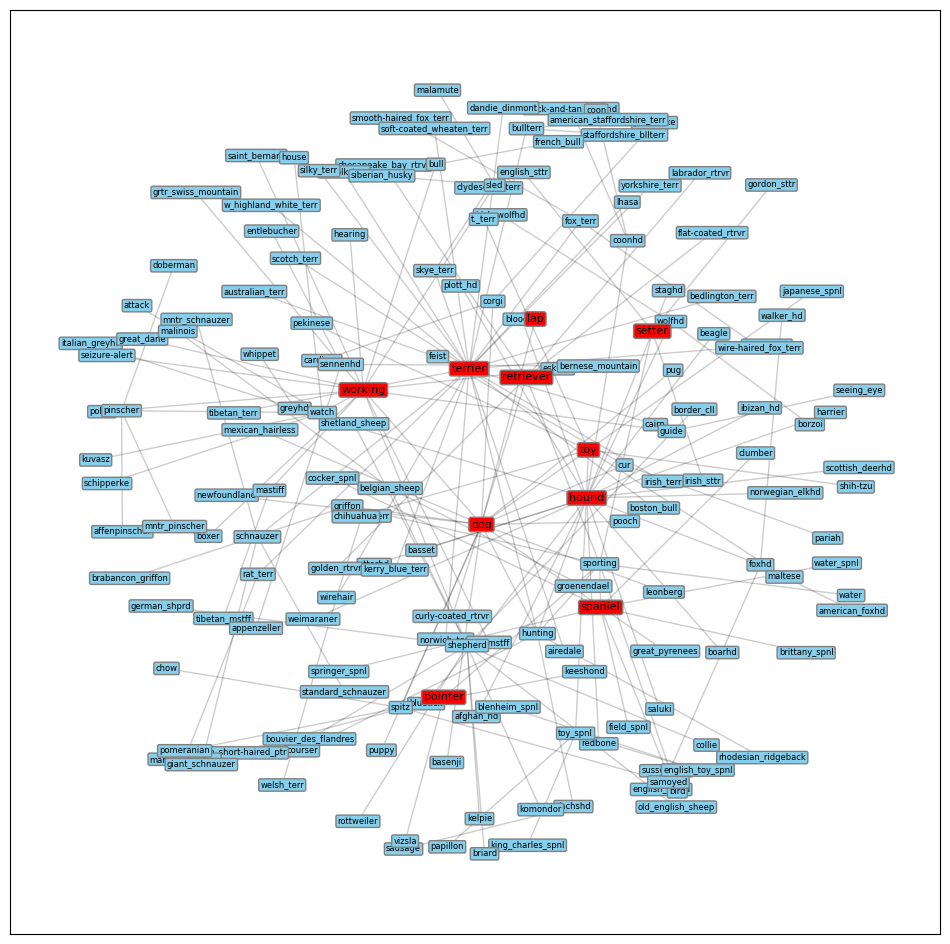

In [26]:
    
## Prepare labels

labels = {n:truncate_name(n) for n in dog_nw.nodes}
# Select some important dog types for highlighting.
dog_types = ['dog','pointer','terrier','hound','lapdog','working_dog','retriever','setter','spaniel',
             'poodle','toy_dog']
dft_labels = {k:(v if v else k) for (k,v) in labels.items() if k not in dog_types}
type_labels = {k:(v if v else k) for (k,v) in labels.items() if k in dog_types}

##  Matplotlib configuring & node layout

plt.figure(figsize=(12,12)) 
fac=6
K=1/math.sqrt(len(dog_nw.nodes()))
seed=58
pos = nx.spring_layout(dog_nw,scale=5.0,k=fac*K,seed=seed) 

## Draw the network

# You can edit the labeldrawing commands out to see the picture without labels
bbox=dict(facecolor="skyblue", edgecolor='gray', boxstyle='round,pad=0.2')
type_bbox=dict(facecolor="red", edgecolor='gray', boxstyle='round,pad=0.2')
nx.draw_networkx_labels(dog_nw,pos,font_size=6,font_color='black',bbox=bbox,labels=dft_labels)
nx.draw_networkx_labels(dog_nw,pos,font_size=8,font_color='black',bbox=type_bbox,labels=type_labels)
nx.draw_networkx_nodes(dog_nw,pos,node_color="none",node_shape='s')

nx.draw_networkx_edges(dog_nw,pos,alpha=.2)

It's fun to edit out the label drawing commands and view the graph without labels.  You can see that label overlap is obscuring a lot of the beauty of the picture.
To deal with the problem of label overlap, we have tried using a small font and resetting the figure size as above. We have also tweaked the value of the `k` parameter in the `spring_layout` function.  The default value  is `K`, as defined above, and we have quintupled it to increase the default distance between nodes (which can still change in the actual rendering due to the needs of the algorithm).  You can try tweaking the figure size and the value of `k` some more to get a better picture but see the networkx notebooks for more robust ideas about how to deal with label placement.  You can also  add the following line at the top of the previous cell

```
%matplotlib qt  
```

This will pop up the matplotlib GUI (the graphic will no longer appear inline in your notebook).  The upside
is that you can   
use the "Zoom to rectangle" tool (maginifying glass icon) in the matplotlib GUI, or the "Edit curves,lines, and axes parameters" tool (Checkmark icon).  You can save in the zoomed state, to use the adjustments to save a cropped or clearer version of the image.

**Note:** The "qt" in the above command specifues the Qt graphics package.  This ia cross-platform graphics package
available for MacOS, Windows and Linux.  You may not have it installed.  In place of "qt" in the above line
you can specify alternative graphics backends:

```
gtk 
osx 
tk
```

GTK and Tk (Tkinter) are also cross-platform.  Os X is for Mac users.  It is possible that neither GTK
nor osx will work on your system; in that case `tk` should work since it is a python module and the graphics
engine is provided along with the Python basic modules.

If you do experiment with the matplotlib GUI, be sure to restart the kernel each time
you try a new backend, and also if you want to go back to inline display.

## Near the Top of WordNet Noun hierarchy

The very top of the WordNet hierarchy is called `entity`.

In [7]:
#import code_networkx as c_nx
from nltk.corpus import wordnet as wn
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt


top = wn.synsets('entity','n')[0]
#dog_nw = c_nx.rel_graph(dog,rel='hyponyms',max_depth=3,prob=.8)
top_nw = rel_graph(top,rel='hyponyms',max_depth=2)
#dog_nw = c_nx.rel_graph(dog)

#person = wn.synsets('person','n')[0]
#person_nw = c_nx.rel_graph(person,rel='hyponyms',max_depth=3,prob=.8)
#person_nw = c_nx.rel_graph(person,rel='hyponyms')
#person_nw = c_nx.rel_graph(person)

In [8]:
len(top_nw)

236

In [9]:
top_nw.nodes()

NodeView(('entity', 'abstraction', 'attribute', 'ballast', 'character', 'cheerfulness', 'common_denominator', 'depth', 'eidos', 'ethos', 'human_nature', 'inheritance', 'personality', 'property', 'quality', 'shape', 'space', 'state', 'thing', 'time', 'trait', 'uncheerfulness', 'communication', 'auditory_communication', 'contagion', 'didacticism', 'display', 'document', 'expressive_style', 'indication', 'language', 'message', 'paralanguage', 'psychic_communication', 'publication', 'sign', 'signal', 'visual_communication', 'voice', 'written_communication', 'group', 'actinoid', 'arrangement', 'association', 'biological_group', 'circuit', 'citizenry', 'collection', 'community', 'edition', 'electron_shell', 'ethnic_group', 'halogen', 'kingdom', 'multitude', 'people', 'population', 'race', 'rare_earth', 'sainthood', 'series', 'social_group', 'straggle', 'subgroup', 'swarm', 'system', 'varna', 'world', 'measure', 'cordage', 'definite_quantity', 'fundamental_quantity', 'indefinite_quantity', 'm

This includes a lot of abstract, hard-to-get-a-handle-on concepts.  Let's go a level down to things
that are physical.

In [11]:
thing = wn.synsets('physical_entity','n')[0]
thing_nw = rel_graph(thing,rel='hyponyms',max_depth=1)

In [12]:
len(thing_nw)

101

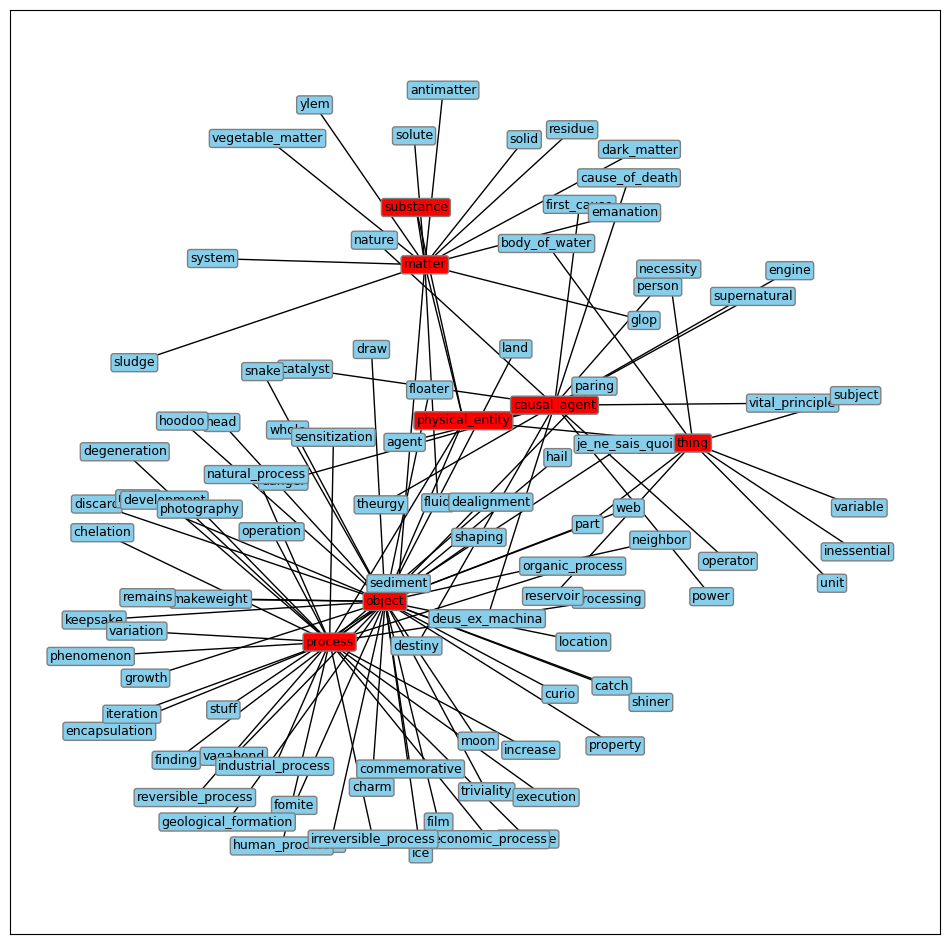

In [20]:
labels = {n:n for n in thing_nw.nodes}
thing_types = ['object','process', 'thing','causal_agent','matter','substance','physical_entity']
dft_labels = {k:(v if v else k) for (k,v) in labels.items() if k not in thing_types}
type_labels = {k:(v if v else k) for (k,v) in labels.items() if k in thing_types}

k=1/math.sqrt(len(thing_nw.nodes()))
import random
seed = random.seed(48)
thing_pos = nx.spring_layout(thing_nw,scale=5.0,k=5*k,seed=seed) 
#top_pos = nx.spring_layout(thing_nw) 

plt.figure(figsize=(12,12))
#thing_labels = {n:truncate_name(n) for n in thing_nw.nodes}
#thing_labels = {n:n for n in thing_nw.nodes}
bbox=dict(facecolor="skyblue", edgecolor='gray', boxstyle='round,pad=0.2')
type_bbox=dict(facecolor="red", edgecolor='gray', boxstyle='round,pad=0.2')

nx.draw_networkx_labels(thing_nw,thing_pos,font_size=9,font_color='black',labels=dft_labels,bbox=bbox)
nx.draw_networkx_labels(thing_nw,thing_pos,font_size=9,font_color='black',labels=type_labels,bbox=type_bbox)
nx.draw_networkx_nodes(thing_nw,thing_pos,node_color='red',node_size=20,node_shape='o')
nx.draw_networkx_edges(thing_nw,thing_pos)